## 1. Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab 
from pylab import *
pylab.rcParams['figure.figsize'] = (16, 6) # size for all figures
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

## 2. Data Preprocessing

**About the Data**

The industrial production index (IPI) is a monthly economic indicator measuring real output in the manufacturing,mining,electric and gas industries, relative to a base year.

It also measures capacity, an estimate of the production levels that could be sustainably maintained and capacity utilization.

**Unit**

It is expressed as an index level relative to a base year (currently 2012) ie. the percentage change in production relative to the base year (2012).

In this specific problem, we would be looking at the ice cream and frozen desert IPI.

<a href='https://fred.stlouisfed.org/series/IPN31152N'>Download Link</a>

In [2]:
df = pd.read_csv('IP_Data.csv',parse_dates=True,index_col='DATE') # parsing the date column as datetime type and setting as index

Note: the above code is a faster way of doing the following:
<pre>df = pd.read_csv('IP_Data.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('Date',inplace=True)</pre>

In [3]:
df.columns = ['IP'] # Renaming the Column for easier use

In [4]:
df.head()

,IP
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='DATE', length=582, freq=None)

In order to build time series models, we need to specify the frequency of the data. Since the observations occur at the start of the month, we will use MS (Monthly Start)

In [6]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='DATE', length=582, freq='MS')

#### We can see that our index consists of datetime64 type which is what we need for Time Series Analysis

In [7]:
print(f'The monthly data consists of values from {df.index.min()} to {df.index.max()}')

The monthly data consists of values from 1972-01-01 00:00:00 to 2020-06-01 00:00:00


## 3. Exploratory Data Analysis (EDA)

Visualizaing the data

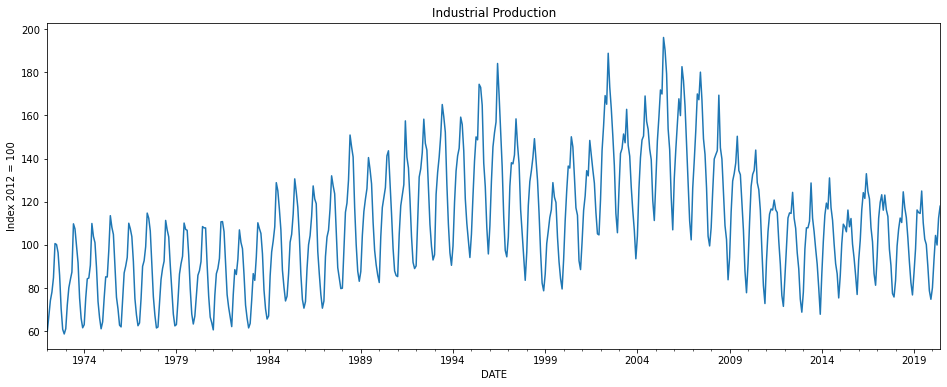

In [8]:
df['IP'].plot(title='Industrial Production').autoscale(axis='x',tight=True)
plt.ylabel('Index 2012 = 100');

#### Rolling Window

**Importance of SMA -** Write here

In [9]:
df['7 Month Mean'] = df['IP'].rolling(window=7).mean() # Rolling mean with window size = 7

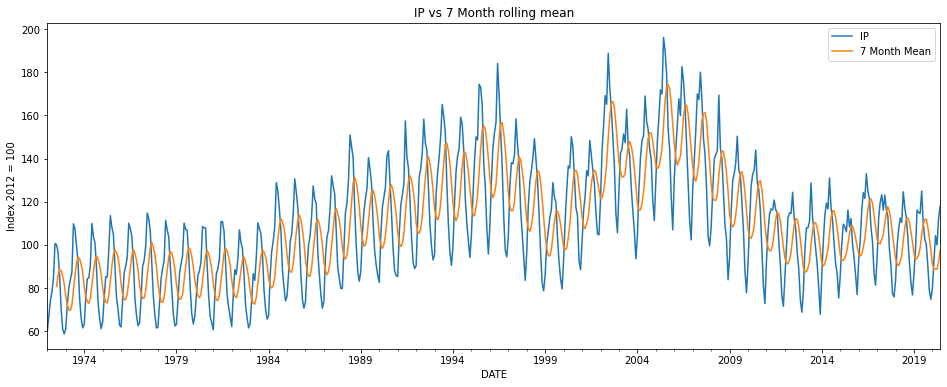

In [10]:
df[['IP','7 Month Mean']].plot(title='IP vs 7 Month rolling mean')
plt.ylabel('Index 2012 = 100');

By resampling based on the time series index, and then aggregating based on chosen rule (offset alias), various insights on the data can be found

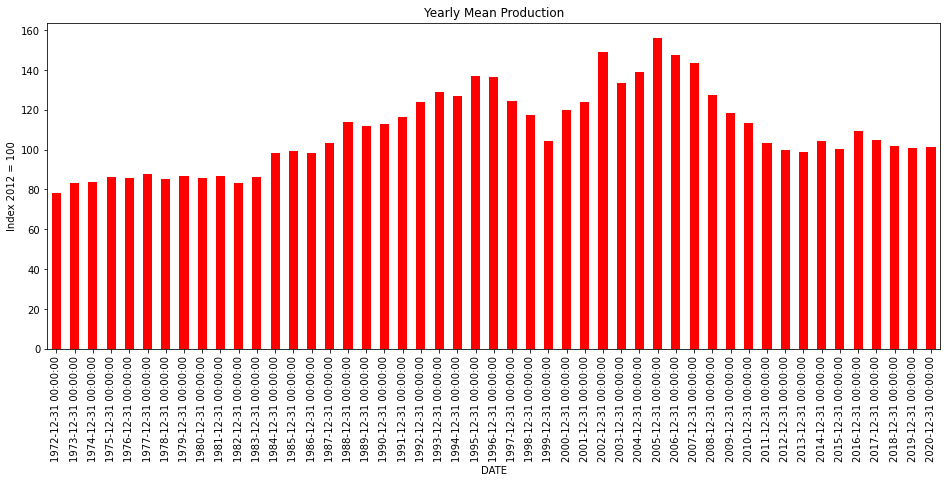

In [11]:
df['IP'].resample(rule='A').mean().plot.bar(figsize=(16,6),title='Yearly Mean Production',color='red')
plt.ylabel('Index 2012 = 100');

#### Hodrick-Prescott Filter

Hodrick-Prescott filter seperates time series into trend and cyclic part

In [12]:
from statsmodels.tsa.filters.hp_filter import hpfilter

wti_cycle,wti_trend = hpfilter(df['IP'],lamb=14400) # lambda-> 100*(number of periods in a year)^2

df['Trend'] = wti_trend

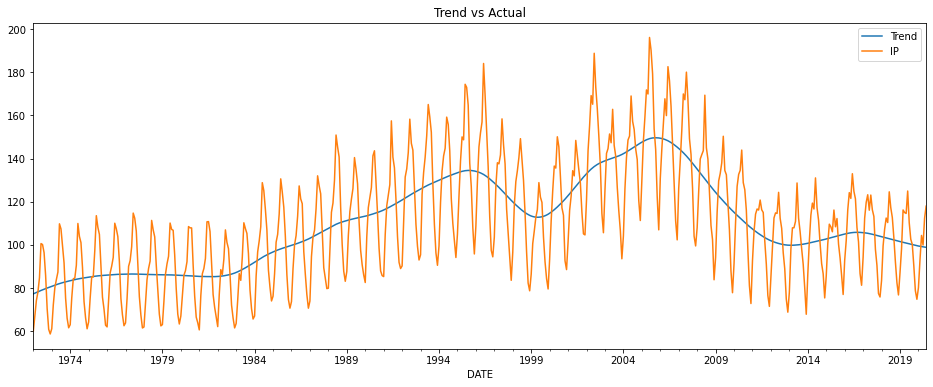

In [13]:
df[['Trend','IP']].plot(title='Trend vs Actual',figsize=(16,6)).autoscale(axis='x',tight=True);

#### ETS Decomposition

The decomposition of a time series attempts to isolate individual components such as error, trend and seasonlaity.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
ets = seasonal_decompose(df['IP'],model='add') # model-> type of seasonality 

Please Check this link to see how to decide whether to use 'additive' or 'multiplicative' seasonality :
https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7

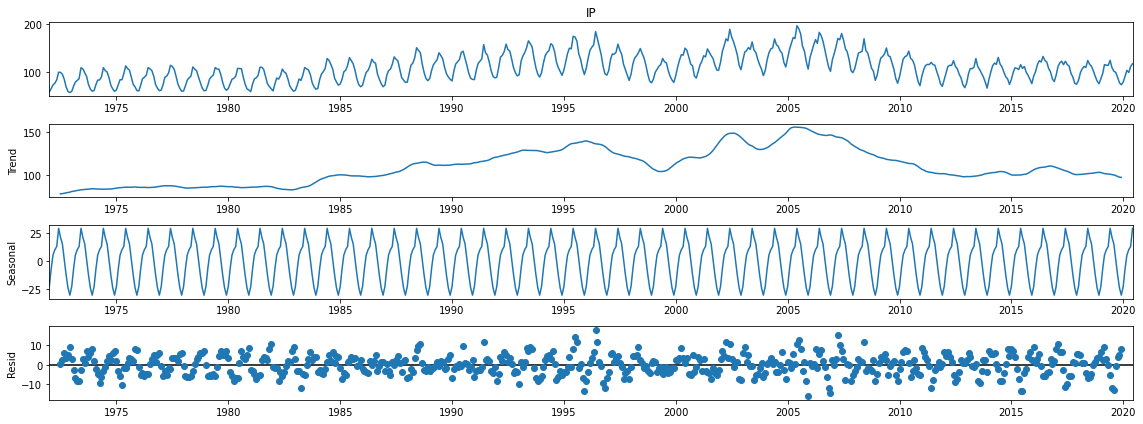

In [15]:
ets.plot();

Outliers / Anomalies ?

#### Train-Test Split

In [16]:
len(df) - 24 # Finding the split point index to keep 2 years (24 months) data as test set

558

In [17]:
train_data = df.iloc[:558]
test_data = df.iloc[558:]

## 4. Forecasting Models

#### a) Holt-Winters (TES)

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['IP'],trend=None,seasonal='add',seasonal_periods=12).fit() # keeping seasonality = 1 year

/Users/vasusingh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [19]:
yhat = fitted_model.predict(len(train_data),len(train_data))

In [20]:
yhat

2018-07-01    119.0985
Freq: MS, dtype: float64

In [21]:
test_predictions = fitted_model.forecast(24).rename('Holt-Winters-Forecast')

In [22]:
test_predictions

2018-07-01    119.098500
2018-08-01    117.115878
2018-09-01    104.486271
2018-10-01     97.505301
2018-11-01     84.237419
2018-12-01     76.217303
2019-01-01     83.676211
2019-02-01     97.961744
2019-03-01    106.815239
2019-04-01    112.430832
2019-05-01    110.539470
2019-06-01    124.498683
2019-07-01    119.098500
2019-08-01    117.115878
2019-09-01    104.486271
2019-10-01     97.505301
2019-11-01     84.237419
2019-12-01     76.217303
2020-01-01     83.676211
2020-02-01     97.961744
2020-03-01    106.815239
2020-04-01    112.430832
2020-05-01    110.539470
2020-06-01    124.498683
Freq: MS, Name: Holt-Winters-Forecast, dtype: float64

In [23]:
compare = pd.DataFrame()

In [24]:
#compare['ForecastDate'] = test_data.index
compare['Actual'] = test_data['IP']
compare['Forecast'] = test_predictions
compare.set_index = test_data.index

In [25]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mean_absolute_error(compare['Actual'],compare['Forecast'])

4.540458177523036

On average, for our test months, we get an absolute error of around 4.5 without any parameter optimizaton.

In [26]:
compare

,Actual,Forecast
DATE,,
2018-07-01,117.2215,119.098500
2018-08-01,112.6779,117.115878
2018-09-01,103.3118,104.486271
2018-10-01,92.1321,97.505301
2018-11-01,82.4347,84.237419
2018-12-01,76.7608,76.217303
2019-01-01,86.9988,83.676211
2019-02-01,98.1116,97.961744
2019-03-01,116.1718,106.815239


## TES Grid Search

In [27]:
# one-step Holt-Winter's exp smoothing forercast
def exp_smoothing_forecast(history,config):
    t,d,s,p,b,r = config 
    # define model
    history = array(history)
    model = ExponentialSmoothing(history,trend=t,damped=d,seasonal=s,seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True,use_boxcox=b,remove_bias=r)
    # make one-step forecast
    yhat = model_fit.predict(len(history),len(history))
    return yhat[0] # returning the first forecast value

In [28]:
# split a univariate dataset into train/test sets
def train_test_split(data,n_test): # n_test -> number of test observations
    test_index = len(data) - n_test # find the starting test index
    return data[:test_index],data[test_index:]

In [29]:
# mean absolute error function
def measure_mae(actual,predicted):
    return mean_absolute_error(actual,predicted)

In [30]:
# walk-forward valiodation for univariate data
def walk_forward_validation(data,n_test,cfg):
    predictions = []
    # 1. split dataset
    train, test = train_test_split(data,n_test)
    history = [x for x in train] # list of historical values
    # loop over each value in the test data
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history,cfg) # yhat will return a single value
        # store the forecast in a list of predictions
        predictions.append(yhat)
        # add actual observation to the history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_mae(test,predictions)
    return error

In [31]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [32]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
        #scores = scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [33]:
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]): # change the seasonal value depending on the data
    models = list()
    # define config lists
    t_params = ['add','mul',None]
    d_params = [True,False]
    s_params = ['add','mul',None]
    p_params = seasonal
    b_params = [True,False]
    r_params = [True,False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models                   

In [34]:
#data = df['IP'].values
data = [10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0]
n_test = 4
cfg_list = exp_smoothing_configs()
scores = grid_search(data,cfg_list,n_test)
print('done')
for cfg,error in scores[:3]:
    print(cfg,error)

KeyboardInterrupt: 

Error ocuring in model thats why None value in score model